In [77]:
from data_analysis.StockDataCombiner import StockDataCombiner

#combiner = StockDataCombiner('../decathlon_scraper/data/sportgear/stocks')
# combined_df = combiner.combine_csv_files()
# combiner.save_combined_data('combined_stock_data.csv')

In [78]:
# read in combine stock data
import pandas as pd
df = pd.read_csv('combined_stock_data.csv')

In [79]:
# list columns
print(df.columns)

Index(['id', 'main_category', 'sub_category', 'product_name', 'brand', 'price',
       'url', 'timestamp', 'store_aboveThreshold', 'store_address',
       'store_availabilityInfo', 'store_clickNcollect1h',
       'store_favoriteStore', 'store_latitude', 'store_longitude',
       'store_optionId', 'store_originId', 'store_phoneNumber',
       'store_priceId', 'store_quantity', 'store_quantityShowroom',
       'store_replenishmentEndDate', 'store_replenishmentStartDate',
       'store_securedStockLevel', 'store_skuId', 'store_storeId',
       'store_storeName', 'store_storeSchedule', 'store_storeUrl'],
      dtype='object')


In [80]:
# for first insight, only relevant considered features are selected
df = df[['id', 'timestamp', 'main_category', 'sub_category', 'product_name', 'brand', 'price', 'store_skuId','store_storeId',
       'store_storeName', 'store_quantity', 'store_availabilityInfo','store_clickNcollect1h']]

# save reduced version as csv
# df.to_csv('reduced_features_stock_data.csv', index=False)

In [81]:
# print df types
print(df.dtypes)

id                        float64
timestamp                  object
main_category              object
sub_category               object
product_name               object
brand                      object
price                      object
store_skuId                object
store_storeId               int64
store_storeName            object
store_quantity              int64
store_availabilityInfo     object
store_clickNcollect1h        bool
dtype: object


In [82]:
# Frequency distribution for categorical fields
for col in df.select_dtypes(include='object').columns:
    print(df[col].value_counts())

timestamp
2024-05-08 11:38:16.396714    103
2024-05-08 11:23:45.017008    103
2024-05-08 11:54:54.446770    103
2024-05-08 11:51:23.015996    103
2024-05-08 11:27:18.400354    103
                             ... 
2024-05-07 20:02:09.566772     20
2024-05-07 20:03:35.181649     20
2024-05-07 20:05:00.463636     20
2024-05-07 20:06:20.286943     20
2024-05-07 19:58:04.018043     20
Name: count, Length: 171, dtype: int64
main_category
fahrrad-welt        1504
basketball          1262
wassersport-welt    1055
padel-tennis         812
fitness              694
camping              651
Name: count, dtype: int64
sub_category
fahrrader                    1504
basketballe-netballe         1262
pools-und-wasserspielzeug    1055
padelausrustung               812
fitnessgerate-fur-zuhause     694
zelte                         651
Name: count, dtype: int64
product_name
City Bike 28 Zoll Elops Speed 500 Singlespeed/Fixie weiss        210
Rennrad – EDR Easy Van Rysel weiss                            

# Analysis of Stock Changes in a single Store (0070048700487 - Würzburg)

In [83]:
import matplotlib.pyplot as plt

df['timestamp'] = pd.to_datetime(df['timestamp'])
filtered_df = df[df['store_storeId'] == 70260002600]  
# Sort the DataFrame
filtered_df = filtered_df.sort_values(by=['id', 'store_skuId', 'timestamp'])
# Create a new column 'previous_quantity' to hold the stock quantity from the previous row
filtered_df['previous_quantity'] = filtered_df.groupby(['id', 'store_skuId'])['store_quantity'].shift(1)

# Create a column to flag changes
filtered_df['quantity_changed'] = filtered_df['store_quantity'] != filtered_df['previous_quantity']

# Filter rows where a change has occurred
changes_df = filtered_df[filtered_df['quantity_changed']]

In [84]:
# print(filtered_df.head())

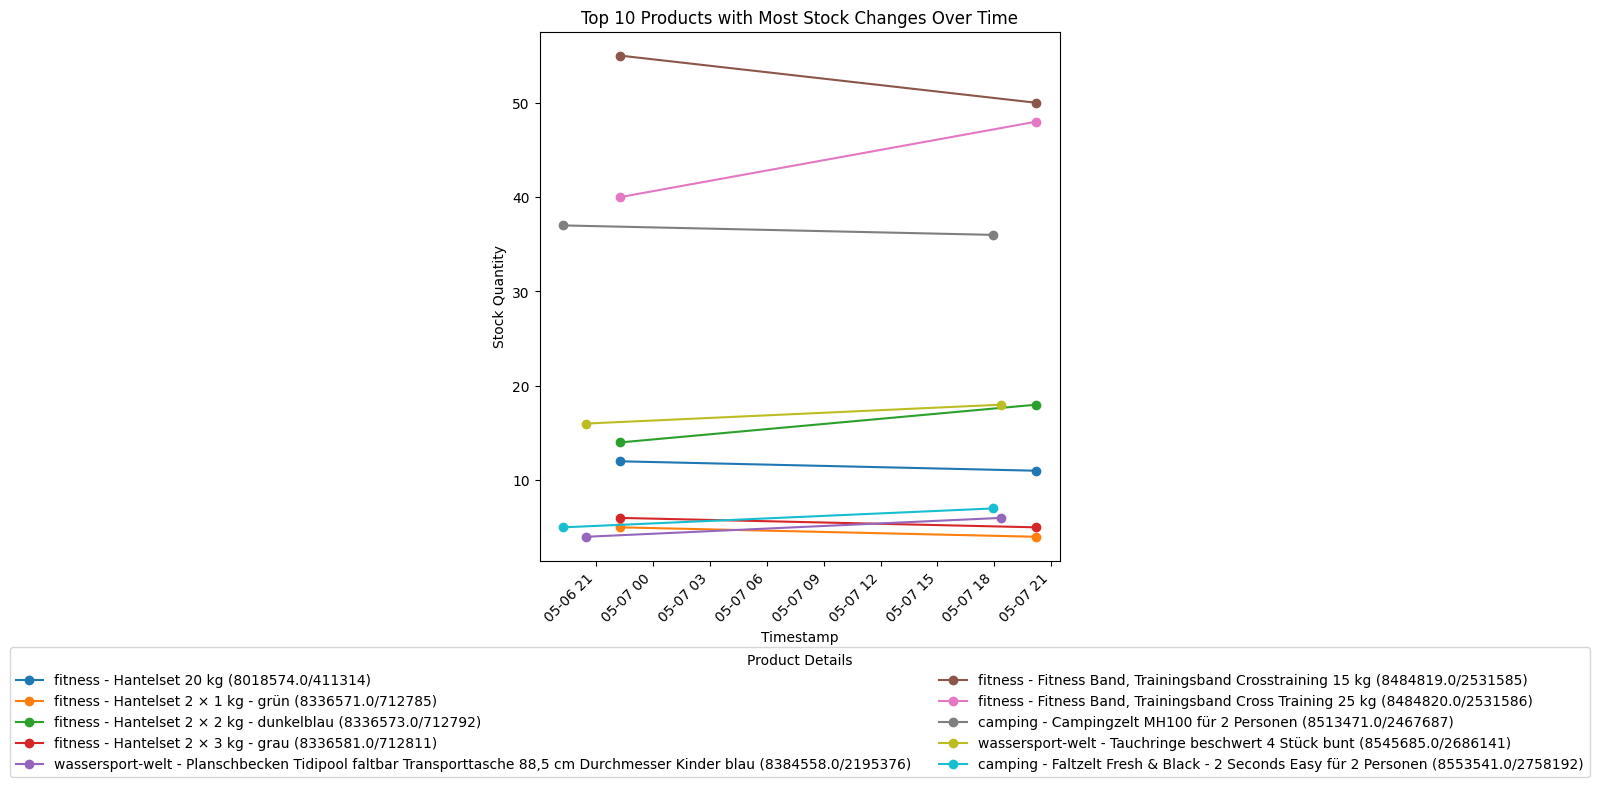

In [86]:
# Count changes for each product and find the top 10
change_counts = changes_df.groupby(['id', 'store_skuId', 'main_category', 'product_name']).size().reset_index(name='change_count')
top_change_products = change_counts.nlargest(10, 'change_count')

# Merge to get only the top 10 products with their respective details
top_changes_df = changes_df.merge(top_change_products, on=['id', 'store_skuId', 'main_category', 'product_name'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for (pid, sku, cat, name), grp in top_changes_df.groupby(['id', 'store_skuId', 'main_category', 'product_name']):
    label = f'{cat} - {name} ({pid}/{sku})'
    grp.plot(x='timestamp', y='store_quantity', ax=ax, label=label, marker='o', linestyle='-')
plt.title('Top 10 Products with Most Stock Changes Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Stock Quantity')
# Place the legend below the plot
plt.legend(title='Product Details', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
